In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import cv2
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

2024-05-12 22:18:20.069046: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-12 22:18:20.069425: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-12 22:18:20.071626: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-12 22:18:20.099600: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-12 22:18:20.613624: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [2]:
USERNAME = '<username>'
KEY = '<user_key>'

In [3]:
# od.download("https://www.kaggle.com/datasets/jessicali9530/stanford-cars-dataset/data")

# EDA

In [4]:
train_anno = pd.read_csv('anno_train.csv', header=None, names=['file', 'x1', 'y1', 'x2', 'y2', 'class_no'])
test_anno = pd.read_csv('anno_test.csv', header=None, names=['file', 'x1', 'y1', 'x2', 'y2', 'class_no'])
classes = pd.read_csv('names.csv', header=None, names=['car'])
classes.index += 1

In [5]:
unique_classes = np.unique(classes)
len(unique_classes)

196

In [6]:
# Path to the dataset
DATASET_DIR = 'stanford-cars-dataset'
TRAIN_DATA_DIR = os.path.join(DATASET_DIR, 'cars_train/cars_train')
TEST_DATA_DIR = os.path.join(DATASET_DIR, 'cars_test/cars_test')

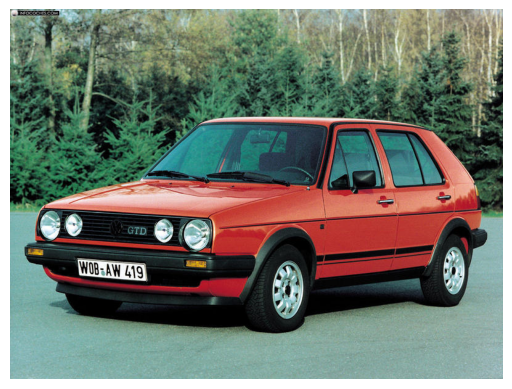

In [7]:
# Function to load images from a directory
def load_images_from_dir(directory):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith('.jpg'): 
            image_path = os.path.join(directory, filename)
            img = Image.open(image_path)
            images.append(img)
    return images

train_images = load_images_from_dir(TRAIN_DATA_DIR)
# train_images.sort(key=lambda x: x.filename)
test_images = load_images_from_dir(TEST_DATA_DIR)
# test_images.sort(key=lambda x: x.filename)

# Visualize a sample image
plt.imshow(train_images[0])
plt.axis('off')
plt.show()

In [8]:
train_images[0].filename

'stanford-cars-dataset/cars_train/cars_train/04240.jpg'

In [9]:
img_row = train_anno.loc[train_anno['file']==train_images[0].filename.split('/')[-1]]
classes.loc[img_row.class_no]

,car
191,Volkswagen Golf Hatchback 1991


In [10]:
len(train_images), len(test_images)

(8144, 8041)

In [11]:
len(train_anno), len(test_anno)

(8144, 8041)

In [12]:
train_anno.head()

,file,x1,y1,x2,y2,class_no
0,00001.jpg,39,116,569,375,14
1,00002.jpg,36,116,868,587,3
2,00003.jpg,85,109,601,381,91
3,00004.jpg,621,393,1484,1096,134
4,00005.jpg,14,36,133,99,106


In [13]:
classes.head()

,car
1,AM General Hummer SUV 2000
2,Acura RL Sedan 2012
3,Acura TL Sedan 2012
4,Acura TL Type-S 2008
5,Acura TSX Sedan 2012


In [14]:
test_anno = test_anno.astype({"class_no": str}, errors='raise')
train_anno = train_anno.astype({"class_no": str}, errors='raise')

# Cropping images

In [15]:
def crop_images(dataset, anno):
    for i in range(len(anno)):
        if dataset == 'train':
            img_path = os.path.join(TRAIN_DATA_DIR, anno.file[i])
            img_output = "./train/" + anno.file[i]
        else:
            img_path = os.path.join(TEST_DATA_DIR, anno.file[i])
            img_output = "./test/" + anno.file[i]

        left = anno.x1[i]
        top = anno.y1[i]
        right = anno.x2[i]
        bottom = anno.y2[i]
        
        img= Image.open(img_path)
        img = img.crop((left, top, right, bottom))
        img.save(img_output)

In [16]:
# os.mkdir('./train')
# crop_images('train', train_anno)

In [17]:
# os.mkdir('./test')
# crop_images('test', test_anno)

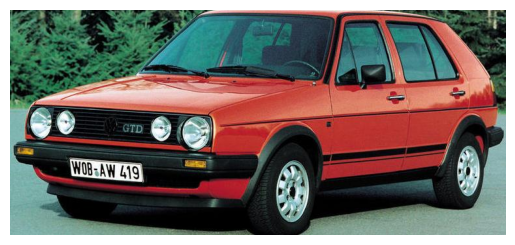

In [18]:
cropped_train_image = load_images_from_dir('./train')[0]

# # Visualize a sample image
plt.imshow(cropped_train_image)
plt.axis('off')
plt.show()

original image:

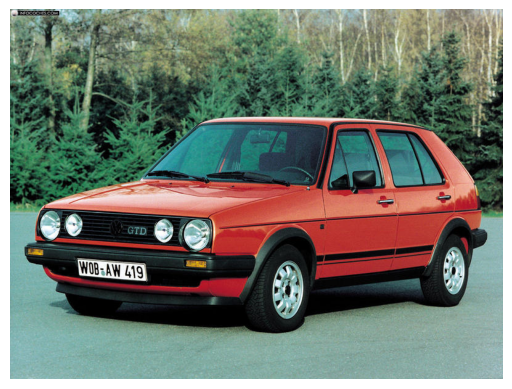

In [19]:
plt.imshow(train_images[0])
plt.axis('off')
plt.show()

## Model

In [20]:
# Target size for resizing images
target_size = (300, 300)

In [21]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)

In [22]:
train_set = train_datagen.flow_from_dataframe(
    dataframe=train_anno,
    directory='./train',
    x_col="file",
    y_col="class_no",
    target_size=(target_size),
    seed=42,
)

test_set = test_datagen.flow_from_dataframe(
    dataframe=test_anno,
    directory='./test',
    x_col="file",
    y_col="class_no",
    target_size=(target_size),
    seed=42,
    shuffle=False
)

Found 8144 validated image filenames belonging to 196 classes.
Found 8041 validated image filenames belonging to 196 classes.


In [23]:
model = Sequential()

model.add(Input(shape=(*(target_size), 3)))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(unique_classes),activation='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 298, 298, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 149, 149, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 147, 147, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 73, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 71, 71, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 35, 35, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 33, 33, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 196)            │       100,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,550,180 (32.62 MB)

 Trainable params: 8,550,180 (32.62 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
callback = EarlyStopping(monitor='loss', mode = "min")
# callback = EarlyStopping(monitor="val_loss",patience=3)

In [25]:
# Train the model
history = model.fit(
    train_set,
    epochs=50,
    validation_data=test_set,
    callbacks=callback,
    batch_size=32
)


Epoch 1/50


/home/damian/Desktop/Data_science/kodolamacz/project/notebook/venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


255/255 ━━━━━━━━━━━━━━━━━━━━ 89s 343ms/step - accuracy: 0.0060 - loss: 5.2615 - val_accuracy: 0.0160 - val_loss: 5.1719
Epoch 2/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 90s 350ms/step - accuracy: 0.0123 - loss: 5.1528 - val_accuracy: 0.0196 - val_loss: 5.0969
Epoch 3/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 89s 347ms/step - accuracy: 0.0201 - loss: 5.0820 - val_accuracy: 0.0226 - val_loss: 5.0517
Epoch 4/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 89s 349ms/step - accuracy: 0.0334 - loss: 4.9758 - val_accuracy: 0.0352 - val_loss: 4.9509
Epoch 5/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 90s 349ms/step - accuracy: 0.0586 - loss: 4.7624 - val_accuracy: 0.0510 - val_loss: 4.8774
Epoch 6/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 89s 348ms/step - accuracy: 0.1073 - loss: 4.4390 - val_accuracy: 0.0548 - val_loss: 4.8481
Epoch 7/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 89s 345ms/step - accuracy: 0.1557 - loss: 4.0574 - val_accuracy: 0.0659 - val_loss: 4.8229
Epoch 8/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 89s 347ms/step - accuracy: 0.2208 - loss: 3.6787 - val

In [26]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_set)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

252/252 ━━━━━━━━━━━━━━━━━━━━ 28s 110ms/step - accuracy: 0.0816 - loss: 8.5972
Test Loss: 8.576083183288574
Test Accuracy: 0.08332297205924988


##### The model was allowed to train for a 50 epochs with a callback option that monitored the validation loss. After the model stopped training for 34 epochs, the accuracy and loss curves below were obtained

In [27]:
# Plot training and validation accuracy
def plot_accuracy_and_loss(history):
    fig, ax = plt.subplots(1, 2)
    ax[0].plot(history.history['accuracy'], label='Training Accuracy')
    ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()
    ax[1].plot(history.history['loss'], label='Training Loss')
    ax[1].plot(history.history['val_loss'], label='Validation Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend()
    plt.tight_layout() 
    plt.show()

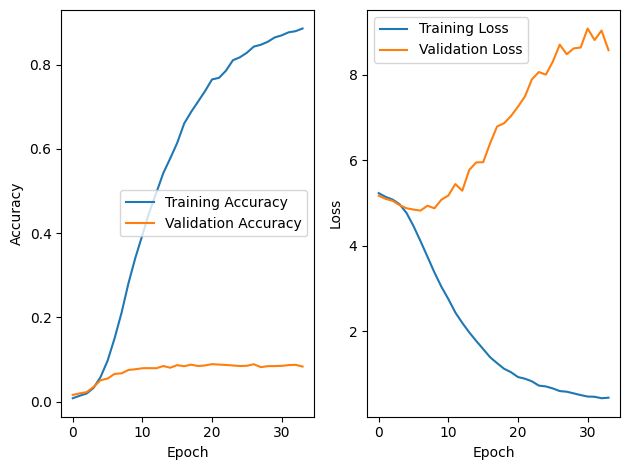

In [28]:
plot_accuracy_and_loss(history)

For this model, the test accuracy was only 8%. Keras Applications (deep learning models that are made available alongside pre-trained weights) to be used in the hope that they would yield higher accuracies.

In [29]:
from tensorflow.keras.applications import ResNet50, ResNet101V2

In [32]:
base_model50 = ResNet50(weights='imagenet', include_top=False, input_shape=(*(target_size), 3))
last_layer = base_model50.layers[-2].output
flatten=Flatten()(last_layer)
out = Dense(units = 196, activation = 'softmax', name = 'ouput')(flatten)
new_base_model50 = Model(inputs = base_model50.input, outputs = out)

for layer in new_base_model50.layers[:-10]:
  layer.trainable = False
  
new_base_model50.compile(optimizer=tf.keras.optimizers.Adam(),
              loss="categorical_crossentropy",
              metrics=['accuracy'])
callback = EarlyStopping(monitor='loss',mode = 'min')

In [33]:
history50 = new_base_model50.fit(
    train_set,
    epochs=100,
    validation_data=test_set,
    callbacks=callback,
    batch_size=32
)

Epoch 1/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 929s 4s/step - accuracy: 0.0065 - loss: 2391.5647 - val_accuracy: 0.0072 - val_loss: 1172.6714
Epoch 2/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 915s 4s/step - accuracy: 0.0107 - loss: 940.1288 - val_accuracy: 0.0073 - val_loss: 862.3254
Epoch 3/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 916s 4s/step - accuracy: 0.0114 - loss: 815.2474 - val_accuracy: 0.0123 - val_loss: 653.5624
Epoch 4/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 909s 4s/step - accuracy: 0.0195 - loss: 655.3198 - val_accuracy: 0.0169 - val_loss: 592.9481
Epoch 5/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 909s 4s/step - accuracy: 0.0296 - loss: 509.0575 - val_accuracy: 0.0173 - val_loss: 411.8062
Epoch 6/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 909s 4s/step - accuracy: 0.0352 - loss: 405.1432 - val_accuracy: 0.0331 - val_loss: 352.3324
Epoch 7/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 909s 4s/step - accuracy: 0.0578 - loss: 301.9638 - val_accuracy: 0.0204 - val_loss: 237.7946
Epoch 8/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 908s 4s/step - accu

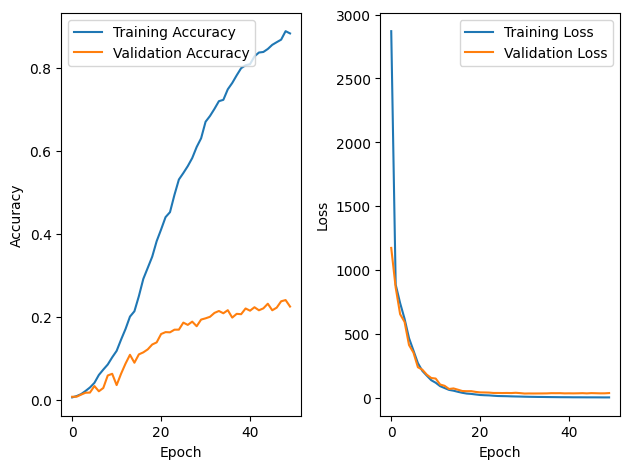

In [34]:
plot_accuracy_and_loss(history50)

In [35]:
base_model101 = ResNet101V2(weights='imagenet', include_top=False, input_shape=(*(target_size), 3))
last_layer = base_model101.layers[-2].output
flatten=Flatten()(last_layer)
out = Dense(units = 196, activation = 'softmax', name = 'ouput')(flatten)
new_base_model101 = Model(inputs = base_model101.input, outputs = out)

for layer in new_base_model101.layers[:-10]:
  layer.trainable = False
  
new_base_model101.compile(optimizer=tf.keras.optimizers.Adam(),
              loss="categorical_crossentropy",
              metrics=['accuracy'])
callback = EarlyStopping(monitor='loss',mode = 'min')

In [36]:
history101 = new_base_model101.fit(
    train_set,
    epochs=100,
    validation_data=test_set,
    callbacks=callback,
    batch_size=32
)

Epoch 1/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 1561s 6s/step - accuracy: 0.0117 - loss: 4524.5073 - val_accuracy: 0.0627 - val_loss: 1273.1038
Epoch 2/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 1547s 6s/step - accuracy: 0.1153 - loss: 976.9143 - val_accuracy: 0.1525 - val_loss: 943.6220
Epoch 3/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 1547s 6s/step - accuracy: 0.2212 - loss: 773.3925 - val_accuracy: 0.2393 - val_loss: 707.3285
Epoch 4/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 1546s 6s/step - accuracy: 0.3967 - loss: 520.1413 - val_accuracy: 0.3164 - val_loss: 655.7542
Epoch 5/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 1547s 6s/step - accuracy: 0.5186 - loss: 383.8182 - val_accuracy: 0.4099 - val_loss: 623.1843
Epoch 6/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 1547s 6s/step - accuracy: 0.5983 - loss: 338.4572 - val_accuracy: 0.4113 - val_loss: 657.4263
Epoch 7/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 1547s 6s/step - accuracy: 0.6727 - loss: 286.1954 - val_accuracy: 0.4369 - val_loss: 681.3082
Epoch 8/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 1547s 6s/ste

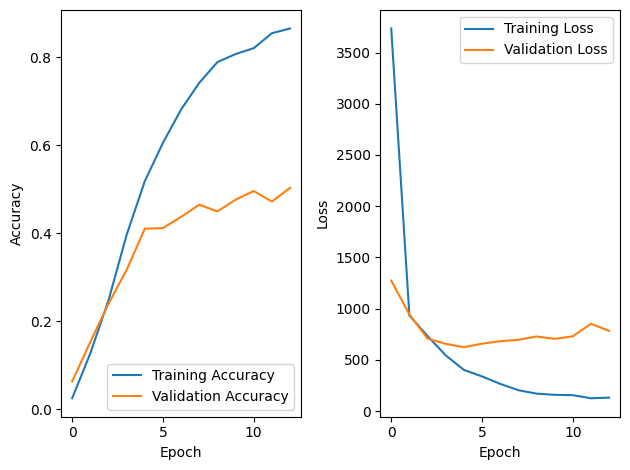

In [37]:
plot_accuracy_and_loss(history101)